# Fine-tuning de Llama 3.2 1B avec LoRA pour l'Inférence en Langage Naturel (NLI)

**Objectif** : Classifier automatiquement la relation entre deux phrases en français (entailment, contradiction, neutral)  
**Modèle** : Llama 3.2 1B avec adaptation LoRA  
**Auteur** : [Votre nom]  
**Date** : Janvier 2026

## 1. Installation et Imports

In [1]:
# Installation des dépendances
!pip install -q transformers>=4.36.0 peft>=0.7.0 \
             datasets>=2.14.0 accelerate>=0.25.0 trl>=0.7.0 scikit-learn

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

# Désactiver wandb
os.environ["WANDB_DISABLED"] = "true"

import pandas as pd
import numpy as np
import torch
from datasets import Dataset
from tqdm.auto import tqdm

from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model, TaskType
from trl import SFTTrainer, SFTConfig
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Vérification GPU
print(f"CUDA disponible : {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU : {torch.cuda.get_device_name(0)}")
    print(f"Mémoire GPU : {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} Go")

2026-01-04 18:24:45.340717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767551085.362840     958 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767551085.369393     958 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767551085.386340     958 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767551085.386362     958 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767551085.386365     958 computation_placer.cc:177] computation placer alr

CUDA disponible : True
GPU : Tesla T4
Mémoire GPU : 15.83 Go


## 2. Authentification Hugging Face

In [3]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient

# Récupération et utilisation du token HF
hf_token = UserSecretsClient().get_secret("HF_TOKEN")
login(token=hf_token)

## 3. Chargement des Données

In [4]:
# Chemins des données
DATA_DIR = "/kaggle/input/nli-french-dataset"

# Chargement des datasets
df_train = pd.read_csv(f"{DATA_DIR}/nli_fr_train.tsv", sep='\t')
df_test = pd.read_csv(f"{DATA_DIR}/nli_fr_test.tsv", sep='\t')

print(f"Train : {len(df_train)} exemples | Test : {len(df_test)} exemples")
print(f"\nDistribution des labels (train) :\n{df_train['label'].value_counts()}")
print(f"\nColonnes : {df_train.columns.tolist()}")

Train : 5010 exemples | Test : 2490 exemples

Distribution des labels (train) :
label
contradiction    1670
entailment       1670
neutral          1670
Name: count, dtype: int64

Colonnes : ['-e premise', 'hypo', 'label']


## 4. Préparation des Données

In [5]:
# Vérifier les noms de colonnes
print("Colonnes du DataFrame:")
print(df_train.columns.tolist())
print("\nPremière ligne:")
print(df_train.iloc[0])

Colonnes du DataFrame:
['-e premise', 'hypo', 'label']

Première ligne:
-e premise    Eh bien, je ne pensais même pas à cela, mais j...
hypo                          Je ne lui ai pas parlé de nouveau
label                                             contradiction
Name: 0, dtype: object


In [6]:
# Prompt SIMPLE (pas le format avec tokens spéciaux)
def create_prompt(premise: str, hypothesis: str, label: str = None) -> str:
    prompt = f"""### Instruction:
Détermine la relation logique entre la Phrase 1 et la Phrase 2.
Réponds uniquement par : entailment, contradiction, ou neutral.

### Phrase 1:
{premise}

### Phrase 2:
{hypothesis}

### Relation:"""
    
    if label is not None:
        prompt += f" {label}"
    
    return prompt

def prepare_dataset(df: pd.DataFrame) -> Dataset:
    """
    Convertit un DataFrame en Dataset Hugging Face.
    """
    # Adapter les noms de colonnes selon votre dataset
    premise_col = 'premise' if 'premise' in df.columns else '-e premise'
    hypo_col = 'hypo' if 'hypo' in df.columns else 'hypothesis'
    
    texts = [create_prompt(row[premise_col], row[hypo_col], row['label']) 
             for _, row in df.iterrows()]
    
    return Dataset.from_dict({
        'text': texts,
        'label': df['label'].tolist()
    })


# Création des datasets
train_dataset = prepare_dataset(df_train)
test_dataset = prepare_dataset(df_test)

print(f"Datasets préparés : {len(train_dataset)} train, {len(test_dataset)} test")
print(f"\nExemple de prompt:\n{train_dataset[0]['text'][:300]}...")

Datasets préparés : 5010 train, 2490 test

Exemple de prompt:
### Instruction:
Détermine la relation logique entre la Phrase 1 et la Phrase 2.
Réponds uniquement par : entailment, contradiction, ou neutral.

### Phrase 1:
Eh bien, je ne pensais même pas à cela, mais j'étais si frustré, et j'ai fini par lui reparler.

### Phrase 2:
Je ne lui ai pas parlé de nou...


## 5. Configuration du Modèle

In [7]:
MODEL_NAME = "meta-llama/Llama-3.2-1B-Instruct"  

# Chargement du modèle en float16 (sans quantification)
print("Chargement du modèle...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    torch_dtype=torch.float16,
    token=hf_token
)

# Chargement du tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, token=hf_token)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

print(f"Modèle chargé : {model.num_parameters():,} paramètres")
print(f"Mémoire GPU utilisée : {torch.cuda.memory_allocated() / 1e9:.2f} Go")

`torch_dtype` is deprecated! Use `dtype` instead!


Chargement du modèle...
Modèle chargé : 1,235,814,400 paramètres
Mémoire GPU utilisée : 1.26 Go


## 6. Configuration LoRA

In [8]:
# Activer le gradient checkpointing pour économiser la mémoire
model.gradient_checkpointing_enable()

# Configuration LoRA
lora_config = LoraConfig(
    r=16,            
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

# Application de LoRA au modèle
model = get_peft_model(model, lora_config)

# Affichage des paramètres entraînables
model.print_trainable_parameters()

trainable params: 1,703,936 || all params: 1,237,518,336 || trainable%: 0.1377


## 7. Entraînement

In [9]:
OUTPUT_DIR = "./llama-nli-lora"

# Configuration de l'entraînement
training_args = SFTConfig(
    output_dir=OUTPUT_DIR,
    num_train_epochs=2,          
    per_device_train_batch_size=4,  
    gradient_accumulation_steps=4,  
    learning_rate=1e-4,           
    warmup_ratio=0.03,
    optim="adamw_torch",
    max_length=256,                 
    logging_steps=20,
    logging_first_step=True,
    save_strategy="no",             
    fp16=True,
    dataset_text_field="text",
    report_to="none",
    gradient_checkpointing=True,
)
# Création du trainer
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    processing_class=tokenizer,
)

print(f"Batch size effectif : {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"Nombre de steps par epoch: {len(train_dataset) // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps)}")

Adding EOS to train dataset:   0%|          | 0/5010 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/5010 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/5010 [00:00<?, ? examples/s]

Batch size effectif : 16
Nombre de steps par epoch: 313


In [10]:
# Lancement de l'entraînement
print("Début de l'entraînement...")
print("Les logs apparaîtront toutes les 20 steps.")
print("="*50)

train_result = trainer.train()

print("="*50)
print(f"Entraînement terminé!")
print(f"Loss finale : {train_result.training_loss:.4f}")
print(f"Temps total : {train_result.metrics['train_runtime']:.0f} secondes")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.


Début de l'entraînement...
Les logs apparaîtront toutes les 20 steps.


Step,Training Loss
1,3.285500
20,3.022400
40,1.957000
60,1.510300
80,1.461100
100,1.429500
120,1.403200
140,1.422200
160,1.413300
180,1.421500


Entraînement terminé!
Loss finale : 1.4652
Temps total : 591 secondes


In [11]:
# Sauvegarde du modèle
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"Modèle sauvegardé dans : {OUTPUT_DIR}")

Modèle sauvegardé dans : ./llama-nli-lora


## 8. Évaluation

In [12]:
def predict_nli(model, tokenizer, premise: str, hypothesis: str) -> str:
    """
    Prédit la relation NLI entre deux phrases.
    """
    prompt = create_prompt(premise, hypothesis)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=10,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = response.split("### Relation:")[-1].strip().lower()
    
    if "entail" in response:     
        return "entailment"
    elif "contradict" in response:  
        return "contradiction"
    elif "neutral" in response:
        return "neutral"
    else:
        return "unknown"

In [13]:
# Prédictions sur le jeu de test
print("Évaluation sur le jeu de test...")

# Adapter les noms de colonnes
premise_col = 'premise' if 'premise' in df_test.columns else '-e premise'
hypo_col = 'hypo' if 'hypo' in df_test.columns else 'hypothesis'

predictions = []
true_labels = df_test['label'].tolist()

for _, row in tqdm(df_test.iterrows(), total=len(df_test)):
    pred = predict_nli(model, tokenizer, row[premise_col], row[hypo_col])
    predictions.append(pred)

print("Évaluation terminée.")

Évaluation sur le jeu de test...


  0%|          | 0/2490 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
Caching is incompatible with gradient checkpointing in LlamaDecoderLayer. Setting `past_key_values=None`.


Évaluation terminée.


In [14]:
# Calcul des métriques
accuracy = accuracy_score(true_labels, predictions)

print(f"\n{'='*50}")
print(f"RÉSULTATS - Llama 3.2 1B + LoRA")
print(f"{'='*50}")
print(f"\nAccuracy : {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"\nRapport de classification :")
print(classification_report(true_labels, predictions, digits=4))


RÉSULTATS - Llama 3.2 1B + LoRA

Accuracy : 0.7040 (70.40%)

Rapport de classification :
               precision    recall  f1-score   support

contradiction     0.7754    0.7277    0.7508       830
   entailment     0.7222    0.7675    0.7442       830
      neutral     0.6176    0.6169    0.6172       830

     accuracy                         0.7040      2490
    macro avg     0.7051    0.7040    0.7041      2490
 weighted avg     0.7051    0.7040    0.7041      2490



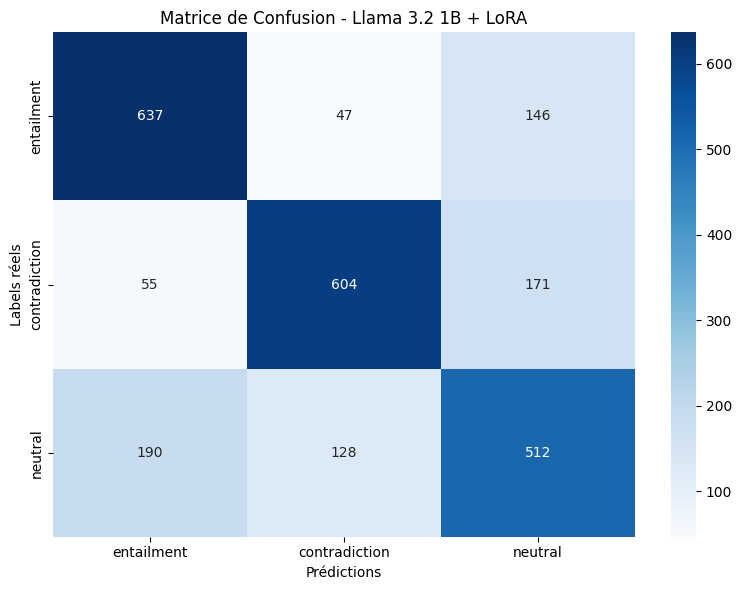

In [15]:
# Matrice de confusion
labels = ['entailment', 'contradiction', 'neutral']
cm = confusion_matrix(true_labels, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Matrice de Confusion - Llama 3.2 1B + LoRA')
plt.xlabel('Prédictions')
plt.ylabel('Labels réels')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

In [16]:
# Sauvegarde des résultats
premise_col = 'premise' if 'premise' in df_test.columns else '-e premise'
hypo_col = 'hypo' if 'hypo' in df_test.columns else 'hypothesis'

results_df = pd.DataFrame({
    'premise': df_test[premise_col],
    'hypothesis': df_test[hypo_col],
    'true_label': true_labels,
    'predicted': predictions,
    'correct': [t == p for t, p in zip(true_labels, predictions)]
})
results_df.to_csv('predictions.csv', index=False)

# Résumé final
print(f"\n{'='*50}")
print("CONFIGURATION EXPÉRIMENTALE")
print(f"{'='*50}")
print(f"Modèle : Llama 3.2 1B")
print(f"LoRA : r={lora_config.r}, alpha={lora_config.lora_alpha}")
print(f"Epochs : {training_args.num_train_epochs}")
print(f"Learning rate : {training_args.learning_rate}")
print(f"Batch size : {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"\nAccuracy finale : {accuracy*100:.2f}%")


CONFIGURATION EXPÉRIMENTALE
Modèle : Llama 3.2 1B
LoRA : r=16, alpha=32
Epochs : 2
Learning rate : 0.0001
Batch size : 16

Accuracy finale : 70.40%
